In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('india-air-quality-2015-2020/Delhi/Delhi-hour.csv')
df

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,01/01/2015 1:00,454.58,935.18,81.52,41.78,187.66,27.54,9.29,3.41,54.94,25.24,58.57,13.80,NaN,NaN
1,01/01/2015 2:00,440.44,NaN,70.80,43.46,176.83,27.72,13.28,3.88,50.53,23.10,49.37,15.63,NaN,NaN
2,01/01/2015 3:00,409.09,NaN,132.46,41.19,141.02,28.94,29.67,2.83,19.33,19.04,38.94,17.18,NaN,NaN
3,01/01/2015 4:00,436.12,NaN,84.78,39.55,102.84,29.30,21.76,4.33,20.08,13.99,27.53,16.82,NaN,NaN
4,01/01/2015 5:00,415.88,976.99,60.24,37.41,80.12,30.84,26.19,6.17,16.00,11.14,21.99,14.29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48187,06/30/2020 20:00,43.19,123.26,6.33,22.28,17.66,29.92,0.92,10.64,44.13,1.63,17.83,0.86,97.0,Satisfactory
48188,06/30/2020 21:00,45.30,125.22,6.34,22.91,17.96,29.95,1.04,10.59,39.62,1.72,18.06,1.16,99.0,Satisfactory
48189,06/30/2020 22:00,49.04,129.39,6.29,20.95,16.80,30.01,1.00,10.20,38.95,1.66,16.17,1.18,101.0,Moderate
48190,06/30/2020 23:00,50.51,128.86,6.19,20.40,16.83,29.40,0.94,10.98,34.53,1.60,16.79,0.85,102.0,Moderate


In [3]:
aqi = df[['AQI', 'AQI_Bucket']]
df = df.drop(columns=['AQI', 'AQI_Bucket'])
aqi.to_csv('india-air-quality-2015-2020/Delhi/aqi.csv', index=False)

In [4]:
df

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
0,01/01/2015 1:00,454.58,935.18,81.52,41.78,187.66,27.54,9.29,3.41,54.94,25.24,58.57,13.80
1,01/01/2015 2:00,440.44,NaN,70.80,43.46,176.83,27.72,13.28,3.88,50.53,23.10,49.37,15.63
2,01/01/2015 3:00,409.09,NaN,132.46,41.19,141.02,28.94,29.67,2.83,19.33,19.04,38.94,17.18
3,01/01/2015 4:00,436.12,NaN,84.78,39.55,102.84,29.30,21.76,4.33,20.08,13.99,27.53,16.82
4,01/01/2015 5:00,415.88,976.99,60.24,37.41,80.12,30.84,26.19,6.17,16.00,11.14,21.99,14.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48187,06/30/2020 20:00,43.19,123.26,6.33,22.28,17.66,29.92,0.92,10.64,44.13,1.63,17.83,0.86
48188,06/30/2020 21:00,45.30,125.22,6.34,22.91,17.96,29.95,1.04,10.59,39.62,1.72,18.06,1.16
48189,06/30/2020 22:00,49.04,129.39,6.29,20.95,16.80,30.01,1.00,10.20,38.95,1.66,16.17,1.18
48190,06/30/2020 23:00,50.51,128.86,6.19,20.40,16.83,29.40,0.94,10.98,34.53,1.60,16.79,0.85


In [27]:
df.isnull().sum()

Datetime        0
PM2.5         375
PM10         2421
NO            298
NO2           330
NOx            25
NH3           980
CO            364
SO2          2852
O3           2201
Benzene        38
Toluene        26
Xylene      18904
dtype: int64

In [28]:
df.head(30)

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
0,01/01/2015 1:00,454.58,935.18,81.52,41.78,187.66,27.54,9.29,3.41,54.94,25.24,58.57,13.80
1,01/01/2015 2:00,440.44,NaN,70.80,43.46,176.83,27.72,13.28,3.88,50.53,23.10,49.37,15.63
2,01/01/2015 3:00,409.09,NaN,132.46,41.19,141.02,28.94,29.67,2.83,19.33,19.04,38.94,17.18
3,01/01/2015 4:00,436.12,NaN,84.78,39.55,102.84,29.30,21.76,4.33,20.08,13.99,27.53,16.82
4,01/01/2015 5:00,415.88,976.99,60.24,37.41,80.12,30.84,26.19,6.17,16.00,11.14,21.99,14.29
5,01/01/2015 6:00,384.16,862.23,59.84,32.06,78.34,30.71,11.04,7.33,12.33,10.70,20.85,12.42
6,01/01/2015 7:00,344.44,731.83,66.55,30.97,84.67,30.64,8.39,8.00,58.67,10.15,19.80,10.35
7,01/01/2015 8:00,337.98,725.74,72.93,26.83,90.44,28.10,7.89,9.00,13.42,11.53,21.53,10.24
8,01/01/2015 9:00,285.22,656.93,69.37,26.22,92.62,31.46,4.25,6.67,55.30,12.10,21.25,9.01
9,01/01/2015 10:00,258.42,525.54,48.56,27.70,80.05,32.75,15.31,6.67,54.28,10.03,18.83,7.45


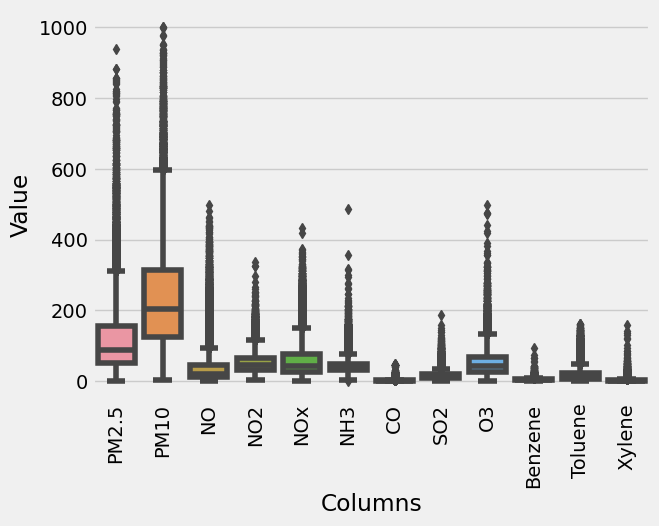

In [29]:
sns.boxplot(data=df)

#modify axis labels
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.ylabel('Value')

plt.show()

In [ ]:
df.plot(figsize=(20,8))

In [6]:
for column in df.columns:
    if column != "Datetime":
        df[column] = df[column].interpolate(method="linear")

In [30]:
def convert_outlier(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    column[column < lower_bound] = np.nan
    column[column > upper_bound] = np.nan
    return column

for column in df.columns:
    if column != 'Datetime':
        df[column] = convert_outlier(df[column])
        df[column] = df[column].interpolate(method='linear')

In [7]:
df.isnull().sum()

Datetime    0
PM2.5       0
PM10        0
NO          0
NO2         0
NOx         0
NH3         0
CO          0
SO2         0
O3          0
Benzene     0
Toluene     0
Xylene      0
dtype: int64

In [32]:
df.head(20)

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
0,01/01/2015 1:00,285.220,525.540000,81.520000,41.78,141.020000,27.54,0.61,3.41,54.94,8.730000,38.94,3.780
1,01/01/2015 2:00,285.220,525.540000,70.800000,43.46,141.020000,27.72,0.61,3.88,50.53,8.730000,38.94,3.780
2,01/01/2015 3:00,285.220,525.540000,77.790000,41.19,141.020000,28.94,0.61,2.83,19.33,8.730000,38.94,3.780
3,01/01/2015 4:00,285.220,525.540000,84.780000,39.55,102.840000,29.30,0.61,4.33,20.08,8.730000,27.53,3.780
4,01/01/2015 5:00,285.220,525.540000,60.240000,37.41,80.120000,30.84,0.61,6.17,16.00,8.730000,21.99,3.780
5,01/01/2015 6:00,285.220,525.540000,59.840000,32.06,78.340000,30.71,0.61,7.33,12.33,8.730000,20.85,3.780
6,01/01/2015 7:00,285.220,525.540000,66.550000,30.97,84.670000,30.64,0.61,8.00,58.67,8.730000,19.80,3.780
7,01/01/2015 8:00,285.220,525.540000,72.930000,26.83,90.440000,28.10,0.61,9.00,13.42,8.730000,21.53,3.780
8,01/01/2015 9:00,285.220,525.540000,69.370000,26.22,92.620000,31.46,0.61,6.67,55.30,8.730000,21.25,3.780
9,01/01/2015 10:00,258.420,525.540000,48.560000,27.70,80.050000,32.75,0.61,6.67,54.28,8.730000,18.83,3.780


In [ ]:
df['Xylene'].fillna(df['Xylene'].mean(), inplace=True)
df['PM2.5'].fillna(df['PM2.5'].mean(), inplace=True)
df['PM10'].fillna(df['PM10'].mean(), inplace=True)
df['NOx'].fillna(df['NOx'].mean(), inplace=True)
df['CO'].fillna(df['CO'].mean(), inplace=True)
df['Benzene'].fillna(df['Benzene'].mean(), inplace=True)
df['Toluene'].fillna(df['Toluene'].mean(), inplace=True)

In [ ]:
df.describe()

In [20]:
df.to_csv('india-air-quality-2015-2020/Delhi/preprocess.csv', index=False)

In [ ]:
for column in df.columns:
  df[column] = df[column].round(decimals=3)

# AQI Calculation

$$ {I_p} = {{{I_{Hi} - I_{Lo}} \over {BP_{Hi} - BP_{Lo}}}(C_p - BP_{Lo}) + I_{Lo}}$$

- $I_p$: the index for pollutant p
- $C_p$: the concentration of pollutant p
- $BP_{Hi}$: the concentration breakpoint that $ \geq C_p$
- $BP_{Lo}$: the concentration breakpoint that $ \leq C_p$
- $I_{Hi}$: the AQI value corresponding to the $BP_{Hi}$
- $I_{Lo}$: the AQI value corresponding to the $BP_{Lo}$


| AQI category (range)  | PM10 (24hr) | PM2.5 (24hr) | NO2 (24hr) | O3 (8hr) | CO (8hr) | SO2 (24hr) | NH3 (24hr) | Pb (24hr) |
|:----------------------|:-----------:|:------------:|:----------:|:--------:|:--------:|:----------:|:----------:|:---------:|
| Good (0–50)           |    0–50     |     0–30     |    0–40    |   0–50   |  0–1.0   |    0–40    |   0–200    |   0–0.5   |
| Satisfactory (51–100) |   51–100    |    31–60     |   41–80    |  51–100  | 1.1–2.0  |   41–80    |  201–400   |  0.5–1.0  |
| Moderate (101–200)    |   101–250   |    61–90     |   81–180   | 101–168  |  2.1–10  |   81–380   |  401–800   |  1.1–2.0  |
| Poor (201–300)        |   251–350   |    91–120    |  181–280   | 169–208  |  10–17   |  381–800   |  801–1200  |  2.1–3.0  |
| Very Poor (301–400)   |   351–430   |   121–250    |  281–400   | 209–748  |  17–34   |  801–1600  | 1200–1800  |  3.1–3.5  |
| Severe (401–500)      |    430+     |     250+     |    400+    |   748+   |   34+    |   1600+    |   1800+    |   3.5+    |

Suppose a monitor records a 24-hour average fine particle (PM2.5) concentration of 26.4 micrograms per cubic meter. The equation above results in an AQI of:

$$ {{\frac {50 - 0}{30 - 0}}(26.4-0)+0=83.2} $$

In [ ]:
df["PM10_24hr_avg"] = df["PM10"].rolling(window = 24, min_periods = 16).mean().values
df["PM2.5_24hr_avg"] = df["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
df["NO2_24hr_avg"] = df["NO2"].rolling(window = 24, min_periods=16).mean().values
df["SO2_24hr_avg"] = df["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["NOx_24hr_avg"] = df["NOx"].rolling(window = 24, min_periods = 16).mean().values
df["NH3_24hr_avg"] = df["NH3"].rolling(window = 24, min_periods = 16).mean().values
df["CO_8hr_max"] = df["CO"].rolling(window = 8, min_periods = 4).max().values
df["O3_8hr_max"] = df["O3"].rolling(window = 8, min_periods = 4).max().values

## PM2.5

In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))


## PM10

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))


## SO2

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 51 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0


df["SO2_SubIndex"] = df["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))

## NOx

In [ ]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0


df["NOx_SubIndex"] = df["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))

## NH3

In [ ]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0


df["NH3_SubIndex"] = df["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))

## CO

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0


df["CO_SubIndex"] = df["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

## O3

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0


df["O3_SubIndex"] = df["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))

# AQI

Following The National Air Quality Index launched in New Delhi on 17/09/2014, under [Swachh Bharat Mission](https://en.wikipedia.org/wiki/Swachh_Bharat_Mission).     
There are six AQI categories, namely Good, Satisfactory, Moderate, Poor, Severe and Hazardous. The proposed AQI will consider eight pollutants (PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb) for which short-term (up to 24-hourly averaging period) National Ambient Air Quality Standards are prescribed.[34] Based on the measured ambient concentrations, corresponding standards and likely health impact, a sub-index is calculated for each of these pollutants. The worst sub-index reflects overall AQI. Likely health impacts for different AQI categories and pollutants have also been suggested, with primary inputs from the medical experts in the group. The AQI values and corresponding ambient concentrations (health breakpoints) as well as associated likely health impacts for the identified eight pollutants are as follows:

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN


df["Checks"] = (
    (df["PM2.5_SubIndex"] > 0).astype(int)
    + (df["PM10_SubIndex"] > 0).astype(int)
    + (df["SO2_SubIndex"] > 0).astype(int)
    + (df["NOx_SubIndex"] > 0).astype(int)
    + (df["NH3_SubIndex"] > 0).astype(int)
    + (df["CO_SubIndex"] > 0).astype(int)
    + (df["O3_SubIndex"] > 0).astype(int)
)

df["AQI_calculated"] = round(
    df[
        [
            "PM2.5_SubIndex",
            "PM10_SubIndex",
            "SO2_SubIndex",
            "NOx_SubIndex",
            "NH3_SubIndex",
            "CO_SubIndex",
            "O3_SubIndex",
        ]
    ].max(axis=1)
)
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

In [ ]:
df[~df.AQI_calculated.isna()].AQI_bucket_calculated.value_counts()

In [ ]:
df.to_csv('india-air-quality-2015-2020/aqi_calculated.csv', index=False)

In [ ]:
df.isnull().sum()